# Introduction:
Following are some of the features that we'll engineer and use in this notebook
1. GuestRooms/Rooms: GuestRooms to Rooms ratio 
2. Number of non-guest rooms: numberOfRooms - GuestRooms
3. Rooms/Floors: Number of rooms per floor
4. Attic/squareMeters:  Attic size to total house size ratio
5. Basement/squareMeters: Basement size to total house size ratio
6. Garage/squareMeters: Garage size to total house size ratio
7. Group city codes into blocks
8. Average price per block

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pathlib import Path
import xgboost as xgb
import lightgbm as lgbm
import catboost
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import optuna
from sklearn.preprocessing import StandardScaler

In [2]:
from warnings import filterwarnings
filterwarnings("ignore")

# Loading Data

In [3]:
# setting a base path variable for easy access
BASE_PATH = Path("/kaggle/input/playground-series-s3e6")
train = pd.read_csv(BASE_PATH / "train.csv").drop(columns=["id"])

test = pd.read_csv(BASE_PATH / "test.csv")
# we need the test id column to make the submission
test_idx = test.id
test = test.drop(columns=["id"])

# we also load original dataset and will try to gauge if adding it to the competition datasets boosts our score or not
original = pd.read_csv("/kaggle/input/paris-housing-price-prediction/ParisHousing.csv")

### Features Presence Check
Checkingg if the competition dataset and original dataset contain the same features in same order, so we can concatenate them easily. Otherwise we'll have to manually make them consistent

In [4]:
all(original.columns == train.columns)

True

#### Result:
Well both dataset indeed contain the same features in the same order. No need for any manual work!

In [5]:
all_datasets = {"train": train, "test": test,"original": original}

# Analyzing Data
Here I won't go in detail about the features distribution similarities and contrasts between the competition and original datasets because that would make this notebook quite complicated for newcomers to this platform and field.

I'll most probably make a separate notebook for this comparison b/w competition and original dataset.

## Checking for missing values

In [6]:
pd.concat([dataset.isnull().sum().rename(f"Missing in {dataset_name}") 
               for dataset_name, dataset in all_datasets.items()],
                 axis=1)

,Missing in train,Missing in test,Missing in original
squareMeters,0,0.0,0
numberOfRooms,0,0.0,0
hasYard,0,0.0,0
hasPool,0,0.0,0
floors,0,0.0,0
cityCode,0,0.0,0
cityPartRange,0,0.0,0
numPrevOwners,0,0.0,0
made,0,0.0,0
isNewBuilt,0,0.0,0


### INSIGHTS:
We're in luck, none of the datasets contain any missing value.

Also test dataframe has **NaN** for price because it doesn't contain price i.e. target feature.

# Preprocess

In [7]:
def preprocess(datasets:dict, target:str):
    """Preprocess the data
        datasets: Expects a dict with datasets name as keys and datasets as values
            Valid names for dataets are: [train, test, original]
        
        target: name of the target column
    """
    for dataset_name, dataset in datasets.items():
        if dataset_name == "train":
            y = train[target]
            X = train.drop(columns=[target])
        elif dataset_name == "original":
            y_org = original[target]
            X_org = original.drop(columns=[target])
        elif dataset_name == "test":
            X_test = test.copy()
        
        
    X_combined = pd.concat([X, X_org], axis=0)
    y_combined = pd.concat([y, y_org], axis=0)

    return {"train": {"data": X, "target": y}, "original": {"data": X_org,  "target": y_org},
            "combined": {"data": X_combined, "target": y_combined}, "test": {"data": X_test}}    

# Cross Validate

In [18]:
def cross_validate(X, y, X_org, y_org, model, model_verbose):
    N_FOLDS = 8
    cv_scores = np.zeros(N_FOLDS)
    feature_importances_all_folds = np.zeros(shape=(N_FOLDS, len(X.columns)))
    feature_names = X.columns
    
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1337)
    
    for fold_num, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # As has been shown in the previous competitions that
        # train on the combined(competition + original) dataset
        # but evaluate only on competition dataset
        
        X_train = pd.concat([X_train, X_org], axis=0)
        y_train = pd.concat([y_train, y_org], axis=0)
        
        if model=="XGBoost":
            model = xgb.XGBRegressor(eval_metric="rmse")
        elif model=="LightGBM":
            model = lgbm.LGBMRegressor()
        elif model=="CatBoost":
            model = catboost.CatBoostRegressor(eval_metric="RMSE")
        
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  early_stopping_rounds=50,
                 verbose=model_verbose)
        
        y_preds = model.predict(X_val)
        
        # to calculate rmse instead of mse, we set squared=False
        rmse = mean_squared_error(y_val, y_preds, squared=False)
        cv_scores[fold_num] = rmse        
        print(f"Fold {fold_num} \t RMSE: {rmse}")
        
        # we'll average feature importances across all folds and plot the averaged values
        feature_importances_all_folds[fold_num] = model.feature_importances_
        
    avg_rmse = np.mean(cv_scores)
    print(f"AVG RMSE: {avg_rmse}")
    
    avg_feature_importances = np.mean(feature_importances_all_folds, axis=0)
    
    plot_feature_importances(feature_names, avg_feature_importances)

# Plot Feature Importances

In [10]:
def plot_feature_importances(feature_names, feature_importances):
    fig = plt.figure(figsize = (15, 0.35*len(feature_importances)))
    feature_imp_df = pd.DataFrame(data=zip(feature_names, feature_importances), columns=["feature", "importance"]).sort_values(by="importance", ascending=False)
    plt.title('Feature importances', size=25, y=1.05)
    sns.barplot(data=feature_imp_df, x='importance', y='feature')
    plt.show()

# Utility Functions

In [11]:
def try_new_feature(X, y, X_org, y_org):    
    models = ["XGBoost", "LightGBM", "CatBoost"]
    
    for model in models:
        print(f"{'-'*20} {model} {'-'*20}")
        
        verbose = False
        if model=="LightGBM":
            verbose = -1
            
        cross_validate(X, y, X_org, y_org, model=model, model_verbose=verbose)

In [22]:
def test_it(all_datasts:dict):
    processed_datasets = preprocess(all_datasets, "price")
    X, y = processed_datasets["train"].values()
    X_org, y_org = processed_datasets["original"].values()

    try_new_feature(X, y, X_org, y_org)

# Setting a baseline

In [13]:
test_it(all_datasets)

-------------------- XGBoost --------------------
Fold 0 	 RMSE: 154188.27278516119
Fold 1 	 RMSE: 127635.99800495614
Fold 2 	 RMSE: 66390.78593262316
Fold 3 	 RMSE: 168424.67336041204
Fold 4 	 RMSE: 73247.73085932412
Fold 5 	 RMSE: 284545.5162397819
Fold 6 	 RMSE: 177638.5351377841
Fold 7 	 RMSE: 63436.759232980054
AVG RMSE: 139438.53394412785
-------------------- LightGBM --------------------
Fold 0 	 RMSE: 171301.47035466178
Fold 1 	 RMSE: 155822.76775984338
Fold 2 	 RMSE: 56447.042274015235
Fold 3 	 RMSE: 202119.25533245484
Fold 4 	 RMSE: 61658.562946096485
Fold 5 	 RMSE: 285890.72441570566
Fold 6 	 RMSE: 209641.8411362364
Fold 7 	 RMSE: 88189.80989517206
AVG RMSE: 153883.9342642732
-------------------- CatBoost --------------------
Fold 0 	 RMSE: 172993.82348787365
Fold 1 	 RMSE: 140587.4331313195
Fold 2 	 RMSE: 31505.182419820227
Fold 3 	 RMSE: 191522.92547325962
Fold 4 	 RMSE: 68043.19116808847
Fold 5 	 RMSE: 278396.3614567066
Fold 6 	 RMSE: 204413.8664501247
Fold 7 	 RMSE: 8168

# Feature Engineering

In [15]:
#  ------------ We need this for our feature number 8 -----------------
train_copy = all_datasets["train"]
train_copy["block_number"] = train_copy.cityCode // 100
# lets find the average house prices for blocks
avg_house_cost_per_block = train_copy.groupby("block_number")["price"].mean().to_dict()
# ---------------------------------------------------------------------------


for _, dataset in all_datasets.items():
    # FeatIdea #1: guestRooms/numberOfRooms
    dataset["guestRooms_/_numberOfRooms"] = dataset.hasGuestRoom / dataset.numberOfRooms
    
    # FeatIdea #2: Number of non guest rooms: NumOfRooms - GuestRooms
    dataset["non_guest_rooms"] = dataset.numberOfRooms - dataset.hasGuestRoom
    
    # FeatIdea #3: Rooms/Floors: Number of rooms per floor
    dataset["NEW_TEST_FEATURE"] = dataset.numberOfRooms // dataset.floors
    
    # FeatIdea #4: Attic/squareMeters:  Attic size to total house size ratio
    dataset["attic_/_squareMeters"] = dataset.attic / dataset.squareMeters
    
    # FeatIdea #5: Basement/squareMeters: Basement size to total house size ratio
    dataset["basement_/_squareMeters"] = dataset.basement / dataset.squareMeters
    
    # FeatIdea #6. Garage/squareMeters: Garage size to total house size ratio
    dataset["garage_/_squareMeters"] = dataset.garage / dataset.squareMeters
    
    # FeatIdea #7: Grouping zip codes
    dataset["block_number"] = dataset.cityCode // 100
    
    # FeatIdea #8: Add avg price per block as a feature.
    dataset["avg_house_price_in_block"] = dataset.block_number.map(avg_house_cost_per_block)

-------------------- XGBoost --------------------
Fold 0 	 RMSE: 155820.77076027213
Fold 1 	 RMSE: 133282.29126587906
Fold 2 	 RMSE: 110214.99812772553
Fold 3 	 RMSE: 160598.05413165977
Fold 4 	 RMSE: 68767.89109840317
Fold 5 	 RMSE: 279296.03419072716
Fold 6 	 RMSE: 174782.13023658236
Fold 7 	 RMSE: 44763.260134608696
AVG RMSE: 140940.67874323225


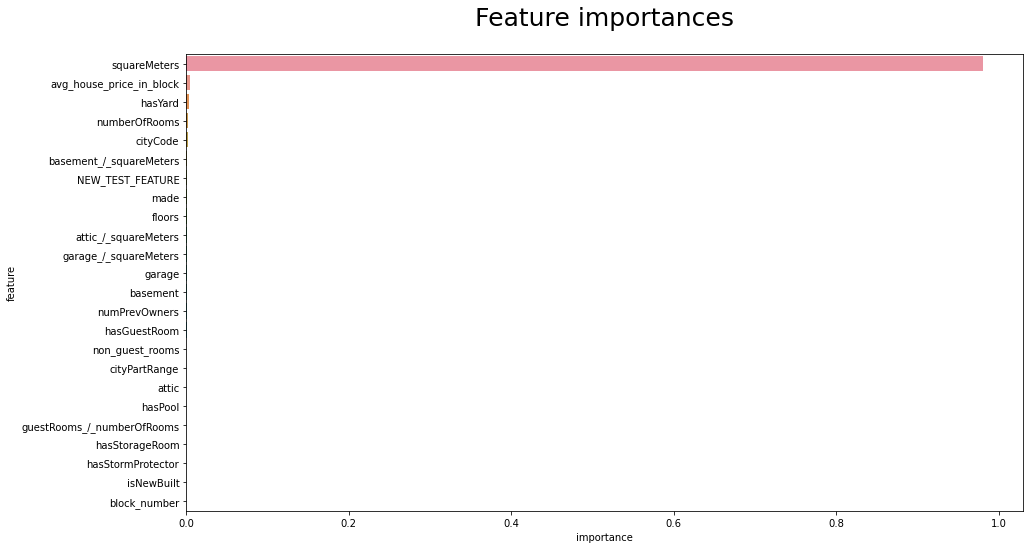

-------------------- LightGBM --------------------
Fold 0 	 RMSE: 171065.73148917555
Fold 1 	 RMSE: 142373.08564585
Fold 2 	 RMSE: 32600.893259980865
Fold 3 	 RMSE: 197856.44162666544
Fold 4 	 RMSE: 59732.4214048116
Fold 5 	 RMSE: 281505.32287431794
Fold 6 	 RMSE: 202593.47804753092
Fold 7 	 RMSE: 78027.1388359189
AVG RMSE: 145719.3141480314


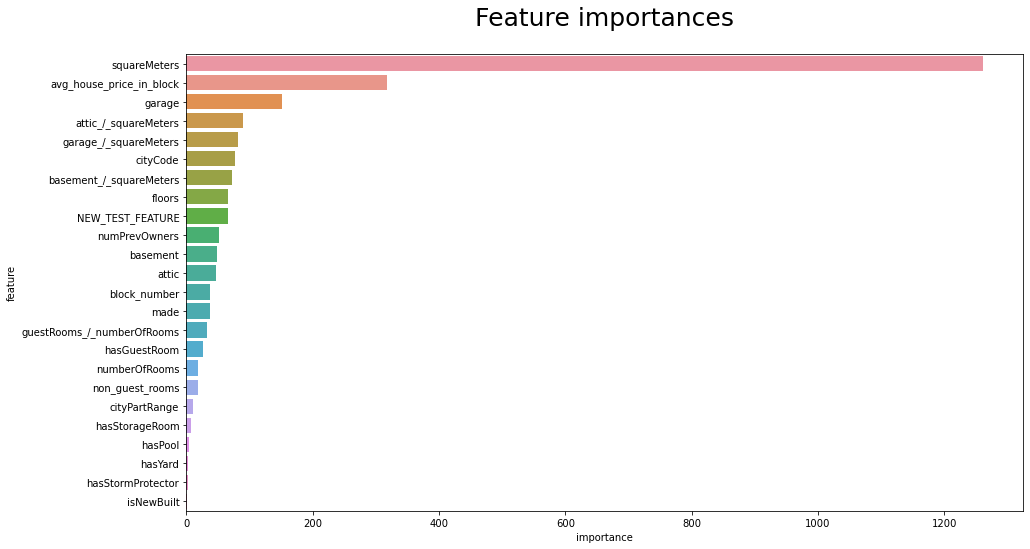

-------------------- CatBoost --------------------
Fold 0 	 RMSE: 168082.84975245385
Fold 1 	 RMSE: 134917.31762861088
Fold 2 	 RMSE: 37478.86212384926
Fold 3 	 RMSE: 188937.61489395995
Fold 4 	 RMSE: 63467.403536153506
Fold 5 	 RMSE: 277341.7629948182
Fold 6 	 RMSE: 187859.62723418634
Fold 7 	 RMSE: 51846.208973857
AVG RMSE: 138741.45589223612


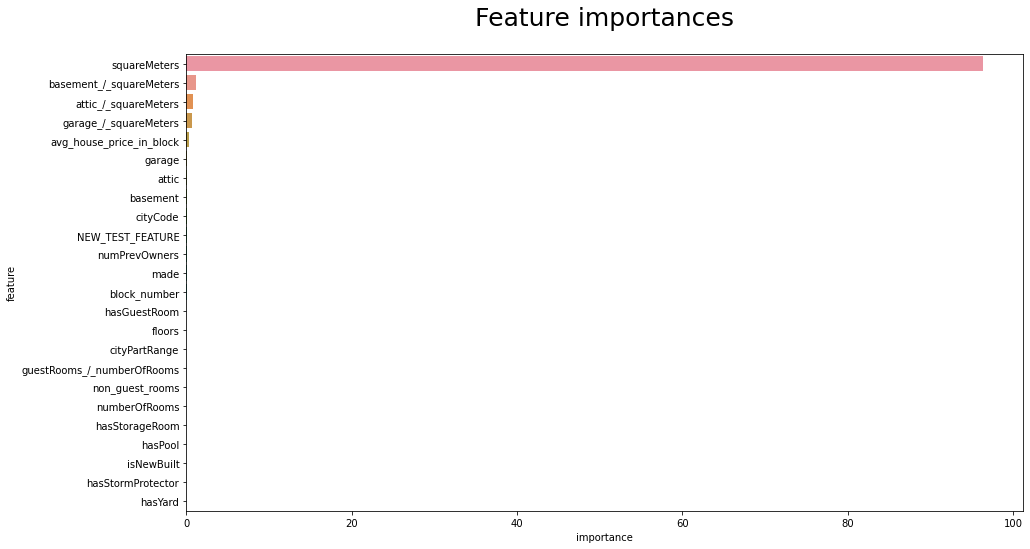

In [19]:
test_it(all_datasets)

## Results:
LightGBM and CatBoost, both show significant imporvement in results.
XGBoost shows a little worse result, though. 

But what's common in all three is that our newly added features seem to be quite important in making decisions.

# Training models

In [31]:
processed_datasets = preprocess(all_datasets, "price")
X_combined, y_combined = processed_datasets["combined"].values()
X_test = processed_datasets["test"]["data"]

In [24]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_combined, y_combined, verbose=False)

lgbm_model = lgbm.LGBMRegressor()
lgbm_model.fit(X_combined, y_combined, verbose=-1)

catboost_model = catboost.CatBoostRegressor()
catboost_model.fit(X_combined, y_combined, verbose=False)

# Ensembling

In [33]:
# y_pred_xgb = xgb_model.predict(X_test)
# y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_cat = catboost_model.predict(X_test)

In [37]:
# y_pred_final = np.array([y_pred_xgb, y_pred_lgbm, y_pred_cat]).mean(axis=0)
y_pred_final = y_pred_cat

In [38]:
submission = pd.DataFrame({'id': test_idx, 'price': y_pred_final})
submission.head()

,id,price
0,22730,4.797407e+06
1,22731,6.169194e+06
2,22732,9.086784e+06
3,22733,1.639660e+06
4,22734,6.741829e+06


In [39]:
submission.to_csv("submission.csv", index=False)